In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
df_train = pd.read_csv("../data/train.csv", sep=',', encoding='utf-8')
df_test = pd.read_csv("../data/test.csv", sep=',', encoding='utf-8')

df_train['texte'] = df_train['titre'] + " " + df_train['ingredients'] + " " + df_train['recette']
df_test['texte'] = df_test['titre'] + " " + df_test['ingredients'] + " " + df_test['recette']

stop_words = set(stopwords.words('french'))

def tokenize_text(text):
    tokens = word_tokenize(text, language="french")
    mal_segmentes = [t for t in tokens if "'" in t]
    # print(mal_segmentes)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_train['tokenize_text'] = df_train['texte'].apply(tokenize_text)
df_test['tokenize_text'] = df_test['texte'].apply(tokenize_text)


model = Word2Vec(sentences=df_train['tokenize_text'], vector_size=100, window=5, min_count=1, workers=4)

def get_vector(words, model):
    words = [word for word in words if word in model.wv]
    return np.mean(model.wv[words], axis=0)

df_train['vector'] = df_train['tokenize_text'].apply(lambda words: get_vector(words, model))
df_test['vector'] = df_test['tokenize_text'].apply(lambda words: get_vector(words, model))


X_train = np.vstack(df_train['vector'].values)
y_train = df_train['type']

X_test = np.vstack(df_test['vector'].values)
y_test = df_test["type"]

svc = SVC(kernel="linear", probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

       Dessert       0.98      0.99      0.99       407
        Entrée       0.74      0.65      0.69       337
Plat principal       0.83      0.88      0.86       644

      accuracy                           0.86      1388
     macro avg       0.85      0.84      0.84      1388
  weighted avg       0.85      0.86      0.85      1388



<Axes: >

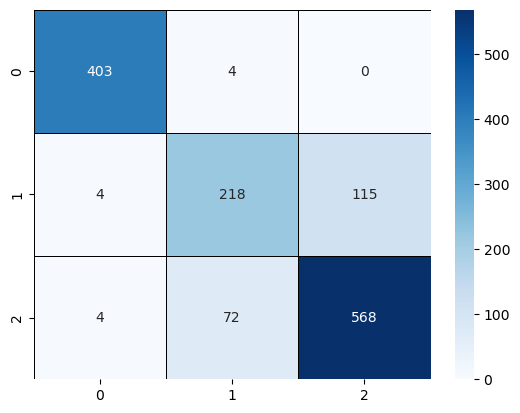

In [3]:
import seaborn as sns 
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")

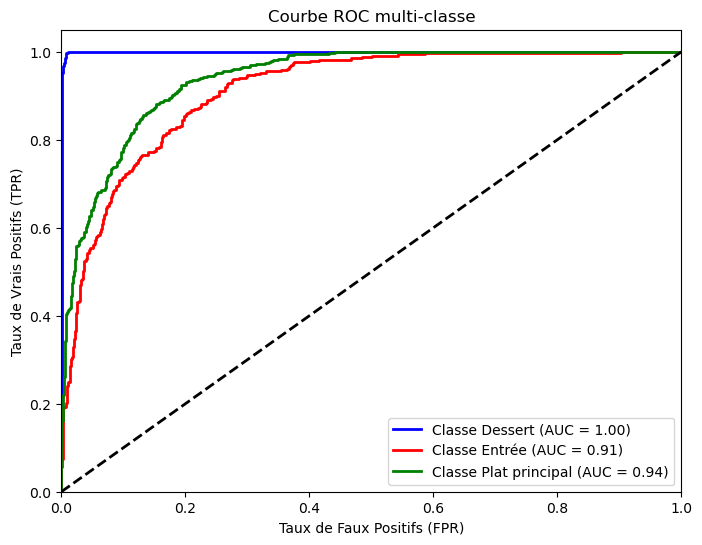

In [4]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = svc.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
colors = cycle(['blue', 'red', 'green']) 

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Classe {lb.classes_[i]} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC multi-classe')
plt.legend(loc='lower right')
plt.show()

In [5]:
max_scores = np.max(y_score, axis=1)
zero_count = np.sum(max_scores == 0)
half_count = np.sum(max_scores < 0.5)
one_count = np.sum((max_scores < 1) & (max_scores > 0.5))


print(f"Documents avec un score de 0   : {zero_count}")
print(f"Documents avec un score de 0.5 : {half_count}")
print(f"Documents avec un score de 1   : {one_count}")

Documents avec un score de 0   : 0
Documents avec un score de 0.5 : 8
Documents avec un score de 1   : 1380


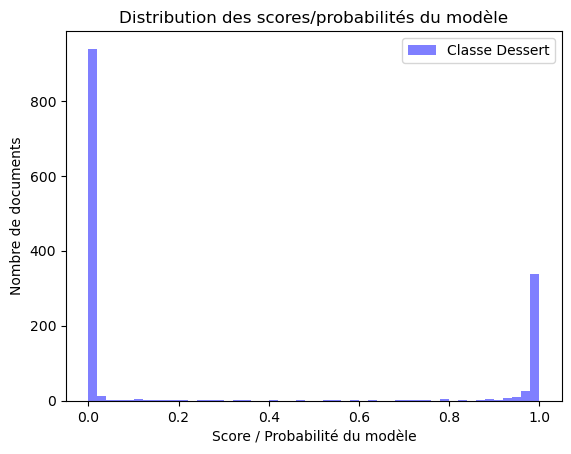

In [6]:
plt.hist(y_score[:, 0], bins=50, color="blue", alpha=0.5, label=f'Classe {lb.classes_[0]}')
plt.xlabel('Score / Probabilité du modèle')
plt.ylabel('Nombre de documents')
plt.title('Distribution des scores/probabilités du modèle')
plt.legend(loc='upper right')
plt.show()

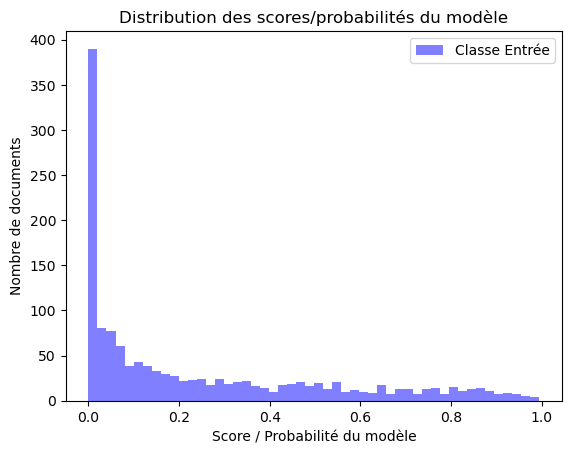

In [7]:
plt.hist(y_score[:, 1], bins=50, color="blue", alpha=0.5, label=f'Classe {lb.classes_[1]}')
plt.xlabel('Score / Probabilité du modèle')
plt.ylabel('Nombre de documents')
plt.title('Distribution des scores/probabilités du modèle')
plt.legend(loc='upper right')
plt.show()

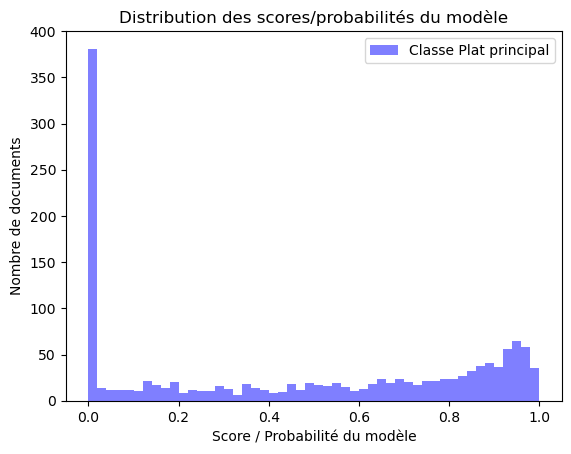

In [8]:
plt.hist(y_score[:, 2], bins=50, color="blue", alpha=0.5, label=f'Classe {lb.classes_[2]}')
plt.xlabel('Score / Probabilité du modèle')
plt.ylabel('Nombre de documents')
plt.title('Distribution des scores/probabilités du modèle')
plt.legend(loc='upper right')
plt.show()